In [10]:
import numpy as np
import os

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.table import Table
from astropy import units as u
import astropy.constants
from astropy.io import ascii,fits

from telfit import Modeler

import scipy.ndimage as scipynd
from scipy.optimize import curve_fit
from astropy import  convolution


DEIMOS_DROPBOX = '/Users/mgeha/Dropbox/DEIMOS/'


Create telluric synthetic models, binned at 0.02AA.   This choice is so that resolution is more than 10x larger than DEIMOS.

In [11]:
# RUN TELFIT SOFTWARE
# INSTALLED FROM https://github.com/freddavies/Telluric-Fitter-py3
# 
def run_telfit(h2o,airmass):
    
    # DEIMOS WAVELENGTH RANGE
    wave_deimos = np.arange(6000,9600,0.02)  # DEFINE 0.01A GRID

    # HARDWIRE TO MAUNA KEA
    alt = 4.2
    lat = 19.8

    # START/END WAVELENGTH IN NM
    wavestart = 600.0
    waveend   = 960.0
           
    #GENERATE A TELLURIC SPECTRUM -- DEFAULT RESOLUTION 0.001AA
    modeler = Modeler()
    print(h2o,airmass)
    angl = np.degrees(np.arccos(1./airmass))

    model = modeler.MakeModel(humidity=h2o,angle=angl,
                          lowfreq=1e7/waveend,
                          highfreq=1e7/wavestart, lat=lat, alt=alt)

    tell = model.toarray()

    # CONVERT TO ANGSTRUM
    wave = 10. * tell[:,0]
    flux = tell[:,1]
    
    # DETERMINE BINNING
    bins = wave - np.roll(wave,1) 
    print('binning = ',np.median(bins))
    
    
    # SMOOTH AND REBIN TO LINEAR 0.02A PIXELS
    sig_res = 0.02/np.median(bins)
    print('Kernal ',sig_res)
    gauss_kernel = convolution.Gaussian1DKernel(sig_res)
    smooth_flux  = convolution.convolve(flux, gauss_kernel)

    tell_flux = np.interp(wave_deimos,wave,smooth_flux)

    plt.plot(wave,flux)
    plt.plot(wave_deimos,tell_flux)
    plt.xlim(6900,6910)
    
    return tell_flux

In [12]:
# DEFINE 0.01A WAVELENGTH GRID
wave_deimos = np.arange(6000,9600,0.02)


In [13]:
# GRID OF PARAMETERS

# FAKE VALUES BETWEEN H2O = 38 to 44
# 44. = 45 
# 42 = 44.2 done
# 40 = 37. done
# 38 = 36.5

# COARSE GRID POINTS
h2o_grid = 1.*np.arange(5,105,5) 
airm_grid = np.arange(1,2.2,0.05)

# FINE GRID POINTS
#h2o_grid = 1.*np.arange(2,102,2) 


5.0 1.0
5.0 1.05
5.0 1.1
5.0 1.1500000000000001
5.0 1.2000000000000002
5.0 1.2500000000000002
5.0 1.3000000000000003
5.0 1.3500000000000003
5.0 1.4000000000000004
5.0 1.4500000000000004
5.0 1.5000000000000004
5.0 1.5500000000000005
5.0 1.6000000000000005
5.0 1.6500000000000006
5.0 1.7000000000000006
5.0 1.7500000000000007
5.0 1.8000000000000007
5.0 1.8500000000000008
5.0 1.9000000000000008
5.0 1.9500000000000008
5.0 2.000000000000001
5.0 2.0500000000000007
5.0 2.100000000000001
5.0 2.1500000000000012
5.0 2.200000000000001
10.0 1.0
10.0 1.05
10.0 1.1
10.0 1.1500000000000001
10.0 1.2000000000000002
10.0 1.2500000000000002
10.0 1.3000000000000003
10.0 1.3500000000000003
10.0 1.4000000000000004
10.0 1.4500000000000004
10.0 1.5000000000000004
10.0 1.5500000000000005
10.0 1.6000000000000005
10.0 1.6500000000000006
10.0 1.7000000000000006
10.0 1.7500000000000007
10.0 1.8000000000000007
10.0 1.8500000000000008
10.0 1.9000000000000008
10.0 1.9500000000000008
10.0 2.000000000000001
10.0 2.050000

80.0 1.9000000000000008
binning =  0.0016136943768287892
Kernal  12.393920612962496
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_80_airm_1.90_.fits
80.0 1.9500000000000008
80.0 1.9500000000000008
binning =  0.0016136943768287892
Kernal  12.393920612962496
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_80_airm_1.95_.fits
80.0 2.000000000000001
80.0 2.000000000000001
binning =  0.0016136943768287892
Kernal  12.393920612962496
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_80_airm_2.00_.fits
80.0 2.0500000000000007
80.0 2.0500000000000007
binning =  0.0016136943768287892
Kernal  12.393920612962496
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_80_airm_2.05_.fits
80.0 2.100000000000001
80.0 2.100000000000001
binning =  0.0016136943768287892
Kernal  12.393920612962496
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_80_airm_2.10_.fits
80.0 2.1500000000000012
80.0 2.15

/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_90_airm_1.50_.fits
90.0 1.5500000000000005
90.0 1.5500000000000005
binning =  0.0016510928007846815
Kernal  12.113189513330205
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_90_airm_1.55_.fits
90.0 1.6000000000000005
90.0 1.6000000000000005
binning =  0.0016510928007846815
Kernal  12.113189513330205
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_90_airm_1.60_.fits
90.0 1.6500000000000006
90.0 1.6500000000000006
binning =  0.0016510928007846815
Kernal  12.113189513330205
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_90_airm_1.65_.fits
90.0 1.7000000000000006
90.0 1.7000000000000006
binning =  0.0016510928007846815
Kernal  12.113189513330205
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_90_airm_1.70_.fits
90.0 1.7500000000000007
90.0 1.7500000000000007
binning =  0.0016510928007846815
Kernal  12.113189513330205
/User

binning =  0.001689554731001408
Kernal  11.837438369425236
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_100_airm_1.15_.fits
100.0 1.2000000000000002
100.0 1.2000000000000002
binning =  0.001689554731001408
Kernal  11.837438369425236
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_100_airm_1.20_.fits
100.0 1.2500000000000002
100.0 1.2500000000000002
binning =  0.001689554731001408
Kernal  11.837438369425236
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_100_airm_1.25_.fits
100.0 1.3000000000000003
100.0 1.3000000000000003
binning =  0.001689554731001408
Kernal  11.837438369425236
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_100_airm_1.30_.fits
100.0 1.3500000000000003
100.0 1.3500000000000003
binning =  0.001689554731001408
Kernal  11.837438369425236
/Users/mgeha/Dropbox/DEIMOS//templates/new_tellurics/telluric_0.02A_h2o_100_airm_1.35_.fits
100.0 1.4000000000000004
100.0 1.400000000000

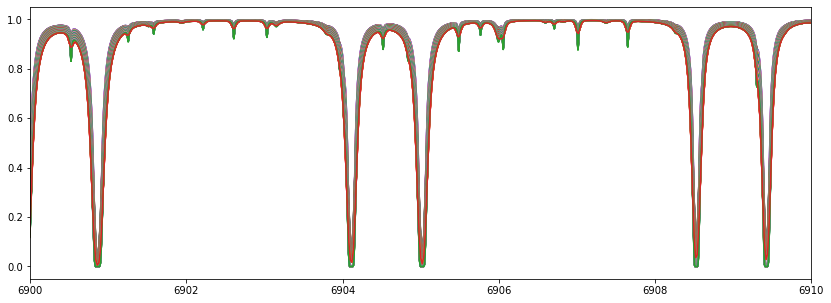

In [14]:
plt.figure(figsize=(14,5))

for h2o in h2o_grid:
    th2o = h2o
               
  
        
        
    for airm in airm_grid:

        # EXTRA '_' for reading purposes
        outname = DEIMOS_DROPBOX + '/templates/new_tellurics/telluric_0.02A_h2o_{}_airm_{:2.2f}_.fits'.format(int(h2o),airm)

        print(h2o,airm)
        
        twave = wave_deimos
        if not os.path.isfile(outname):
            tflux = run_telfit(th2o,airm)
            print(outname)

            t = Table([twave,tflux], names=('wave', 'flux'))
            t.meta['h2o'] = h2o
            t.meta['airmass']  = airm

            t.write(outname, format='fits')

In [5]:
plt.figure(figsize=(14,5))


<Figure size 1008x360 with 0 Axes>

<Figure size 1008x360 with 0 Axes>

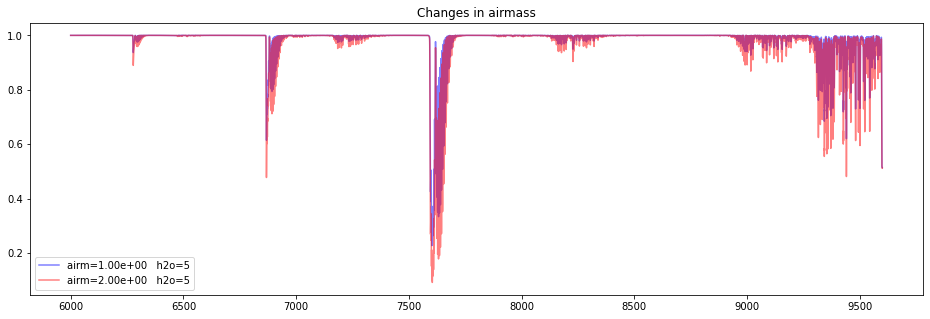

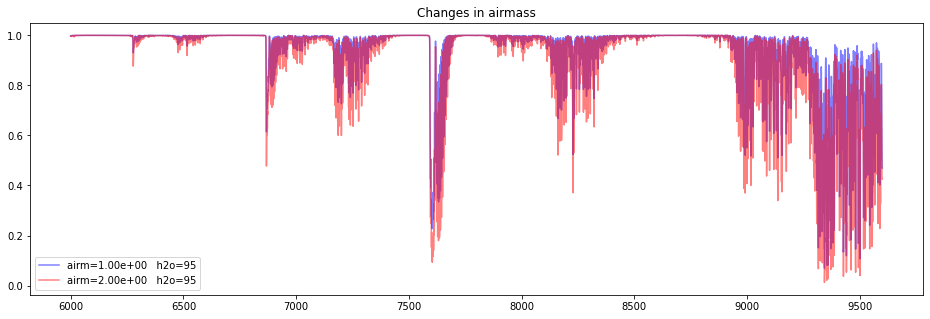

In [15]:
clr = ['blue','red']
h2o_val = np.array([5,95])
airm_val = np.array([1.0,2.0])

losvd_pix = 0.5/0.02

for h2o in h2o_val:
    
    plt.figure(figsize=(16,5))
    for airm,c in zip(airm_val,clr):
        tfile = DEIMOS_DROPBOX + '/templates/new_tellurics/telluric_0.02A_h2o_{}_airm_{:2.2f}_.fits'.format(int(h2o),airm)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        t = 'airm={:0.2e}   h2o={:0.0f}'.format(airm,h2o)
        plt.plot(twave,cflux,alpha=0.5,label=t,color=c)
        plt.title('Changes in airmass')

    plt.legend()
#plt.xlim(8200,8500)

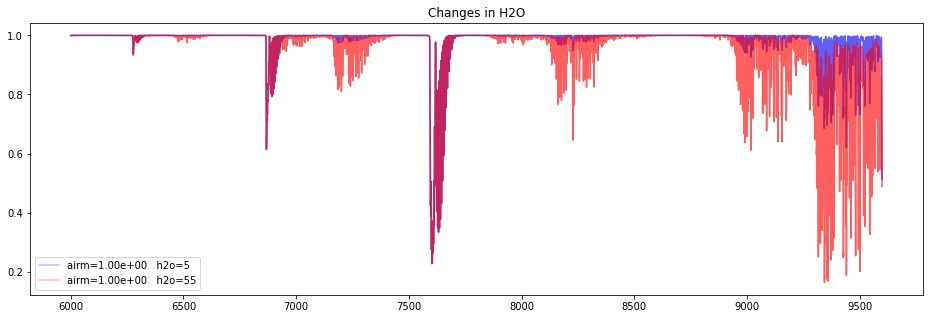

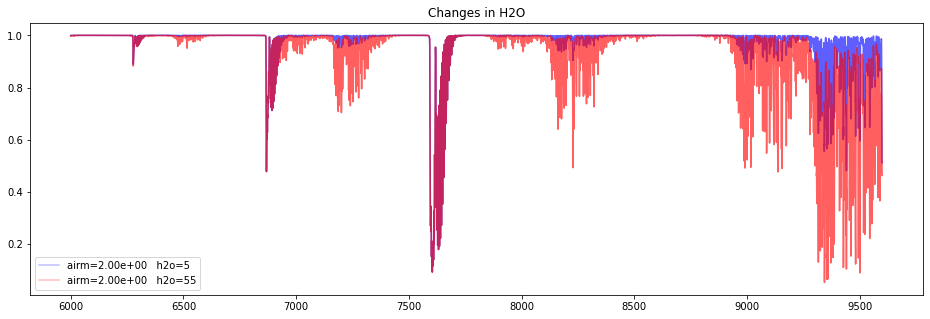

In [9]:
clr = ['blue','red']

for airm in airm_val:
    
    plt.figure(figsize=(16,5))
    for h2o,c in zip(h2o_val,clr):
        tfile = DEIMOS_DROPBOX + '/templates/new_tellurics/telluric_0.02A_h2o_{}_airm_{:2.2f}_.fits'.format(int(h2o),airm)
        
        hdu  = fits.open(tfile)
        data =  hdu[1].data
        twave = np.array(data['wave']).flatten()
        tflux = np.array(data['flux']).flatten()

 
        cflux = scipynd.gaussian_filter1d(tflux,losvd_pix)#,mode='nearest')
        plt.plot(twave,cflux,alpha=0.5,color=c)
        t = 'airm={:0.2e}   h2o={:0.0f}'.format(airm,h2o)
        plt.plot(twave,cflux,alpha=0.25,label=t,color=c)
        plt.title('Changes in H2O')
    plt.legend()
   # plt.xlim(8100,8350)